### Importing Libraries

To work with data and create visualizations, we will import the following libraries:

- **`pandas`**: A powerful library for data manipulation and analysis, providing data structures like DataFrames.
- **`numpy`**: A library for numerical operations, useful for working with arrays and performing mathematical computations.
- **`matplotlib.pyplot`**: A plotting library for creating a variety of static, animated, and interactive plots.


In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


### Generating a Road Image

The `generate_road_image` function creates a synthetic image of a road with simple lane markings.

#### Parameters:

- **`width`**: Width of the image in pixels (default is 640).
- **`height`**: Height of the image in pixels (default is 480).

#### Functionality:

- **Create Image**: Generates a grey image of the specified size.
- **Draw Lane Markings**: Adds two white lines to simulate lane markings.

Returns the generated image for use in simulations or testing.


In [19]:

def generate_road_image(width=640, height=480):
    image = np.zeros((height, width, 3), dtype=np.uint8)
    image.fill(100)
    cv2.line(image, (width//4, height), (width//3, height//2), (255, 255, 255), 5)
    cv2.line(image, (3*width//4, height), (2*width//3, height//2), (255, 255, 255), 5)
    return image


### Preprocessing an Image

The `preprocess_image` function prepares an image for further processing by converting it to grayscale and applying Gaussian blur.

#### Parameters:

- **`image`**: The input image in RGB format.

#### Functionality:

1. **Convert to Grayscale**: Transforms the image from RGB to grayscale.
2. **Apply Gaussian Blur**: Reduces noise and detail with a Gaussian blur.

Returns the processed image ready for additional analysis or processing.


In [20]:

def preprocess_image(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    return blur


### Detecting Edges in an Image

The `detect_edges` function applies edge detection to an image using the Canny algorithm.

#### Parameters:

- **`image`**: The input image, typically preprocessed to grayscale and blurred.

#### Functionality:

- **Apply Canny Edge Detection**: Detects edges in the image using specified thresholds.

Returns an image highlighting the detected edges.


In [21]:
def detect_edges(image):
    return cv2.Canny(image, 50, 150)

### Defining a Region of Interest

The `region_of_interest` function isolates a triangular region in an image for further analysis.

#### Parameters:

- **`image`**: The input image from which the region of interest will be extracted.

#### Functionality:

1. **Define Polygon**: Creates a triangular mask covering the bottom half of the image.
2. **Create Mask**: Fills the polygon with white on a black background.
3. **Apply Mask**: Applies the mask to the image to retain only the region of interest.

Returns the image with only the specified region visible.


In [22]:
def region_of_interest(image):
    height, width = image.shape
    polygon = np.array([[(0, height), (width, height), (width//2, height//2)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygon, 255)
    return cv2.bitwise_and(image, mask)

### Detecting Lines in an Image

The `detect_lines` function identifies straight lines in an image using the Hough Line Transform. It processes edge-detected images to find and return line segments. 


In [23]:
def detect_lines(image):
    return cv2.HoughLinesP(image, 1, np.pi/180, 50, minLineLength=50, maxLineGap=100)

### Averaging Slope and Intercept of Lines

The `average_slope_intercept` function calculates the average slope and intercept for detected left and right lines.

#### Functionality:

- **Classify Lines**: Separates lines into left and right based on their slope.
- **Compute Averages**: Calculates the average slope and intercept for each side.

Returns the average slope and intercept for left and right lines.


In [24]:

def average_slope_intercept(lines):
    left_lines, right_lines = [], []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 == x1:
            continue
        slope = (y2 - y1) / (x2 - x1)
        intercept = y1 - slope * x1
        (left_lines if slope < 0 else right_lines).append((slope, intercept))
    
    left_avg = np.average(left_lines, axis=0) if left_lines else None
    right_avg = np.average(right_lines, axis=0) if right_lines else None
    return left_avg, right_avg


### Creating Lane Lines on an Image

The `create_lane_lines` function draws lane lines on an image based on the average slopes and intercepts of detected lines.

#### Functionality:

- **Compute Line Endpoints**: Uses the average slope and intercept to calculate line endpoints.
- **Draw Lines**: Draws the left and right lane lines on the image.

Modifies the input image to include visual lane lines.


In [25]:

def create_lane_lines(image, lines):
    left_avg, right_avg = average_slope_intercept(lines)
    y1, y2 = image.shape[0], int(image.shape[0] * 0.6)

    if left_avg is not None:
        left_x1 = int((y1 - left_avg[1]) / left_avg[0])
        left_x2 = int((y2 - left_avg[1]) / left_avg[0])
        cv2.line(image, (left_x1, y1), (left_x2, y2), (255, 0, 0), 5)

    if right_avg is not None:
        right_x1 = int((y1 - right_avg[1]) / right_avg[0])
        right_x2 = int((y2 - right_avg[1]) / right_avg[0])
        cv2.line(image, (right_x1, y1), (right_x2, y2), (255, 0, 0), 5)


### Lane Detection

The `lane_detection` function detects and highlights lane lines in an image.

#### Functionality:

1. **Preprocess Image**: Converts to grayscale and applies blur.
2. **Detect Edges**: Finds edges using the Canny edge detector.
3. **Define Region of Interest**: Focuses on a specific area of the image.
4. **Detect Lines**: Identifies lines in the region of interest.
5. **Draw Lane Lines**: Creates and overlays lane lines on the original image.

Returns the image with detected lane lines highlighted.


In [26]:

def lane_detection(image):
    preprocessed = preprocess_image(image)
    edges = detect_edges(preprocessed)
    roi = region_of_interest(edges)
    lines = detect_lines(roi)
    
    if lines is not None:
        lane_image = np.zeros_like(image)
        create_lane_lines(lane_image, lines)
        return cv2.addWeighted(image, 0.8, lane_image, 1, 1)
    else:
        return image


### Lane Detection Visualizer

The `LaneDetectionVisualizer` class provides a step-by-step visualization of the lane detection process.

#### Functionality:

1. **Initialize Images**: Generates a road image and sets up visualization steps.
2. **Visualization Steps**: Defines a sequence of processing stages:
   - **Original Image**
   - **Grayscale**
   - **Edge Detection**
   - **Region of Interest**
   - **Lane Detection**
3. **Display**: Uses Matplotlib to display each processing step in a series of subplots.

Provides a visual overview of how lane detection transforms the image through each stage.


In [27]:

class LaneDetectionVisualizer:
    def __init__(self):
        self.road_image = generate_road_image()
        self.steps = [
            ("Original Image", lambda: self.road_image),
            ("Grayscale", lambda: cv2.cvtColor(preprocess_image(self.road_image), cv2.COLOR_GRAY2RGB)),
            ("Edge Detection", lambda: cv2.cvtColor(detect_edges(preprocess_image(self.road_image)), cv2.COLOR_GRAY2RGB)),
            ("Region of Interest", lambda: cv2.cvtColor(region_of_interest(detect_edges(preprocess_image(self.road_image))), cv2.COLOR_GRAY2RGB)),
            ("Lane Detection", lambda: lane_detection(self.road_image))
        ]
        
        self.fig, self.axes = plt.subplots(nrows=1, ncols=len(self.steps), figsize=(20, 6))
        self.fig.subplots_adjust(hspace=0.5, wspace=0.5)
        
        for ax, (step_name, step_func) in zip(self.axes, self.steps):
            ax.imshow(step_func())
            ax.set_title(step_name)
            ax.axis('off')


### Create and Show Lane Detection Visualizer

The following code initializes the `LaneDetectionVisualizer` and displays the visualizations of each processing step.


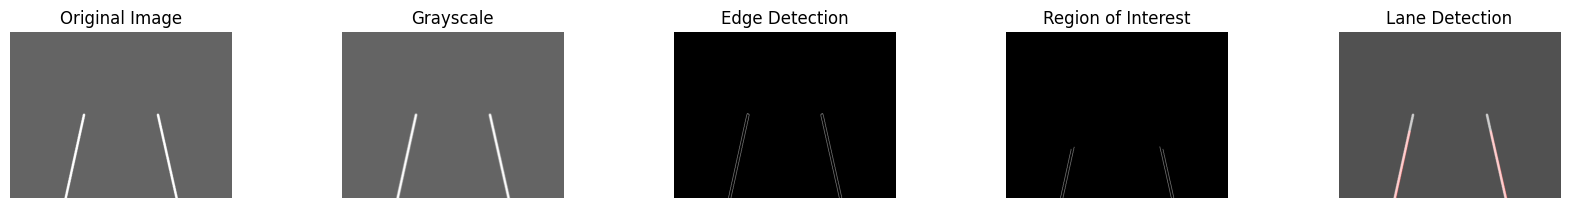

In [28]:

# Create and show the visualizer
visualizer = LaneDetectionVisualizer()
plt.show()